In [1]:
!pip install segmentation_models_pytorch

Необходимо подготовить датасет https://www.kaggle.com/olekslu/makeup-lips-segmentation-28k-samples для обучения модели на сегментацию губ

Обучить модель на выбор из segmentation_models_pytorch

In [2]:
import os
import time

import numpy as np
import pandas as pd

from pathlib import Path
from PIL import Image

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import cv2

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

import segmentation_models_pytorch as smp

C:\Users\User\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
dataset_file = 'C:/Users/User/First/PyTorch/lips_segmentation/list.csv'
images_path = 'C:/Users/User/First/PyTorch/lips_segmentation/720p/'
masks_path = 'C:/Users/User/First/PyTorch/lips_segmentation/mask/'

In [4]:
df = pd.read_csv(dataset_file)
df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png
2,image00000003.jpg,1280,720,Lips,553,369,684,427,mask00000003.png
3,image00000004.jpg,1280,720,Lips,555,351,681,408,mask00000004.png
4,image00000005.jpg,1280,720,Lips,555,351,680,407,mask00000005.png


In [5]:
files_names_list = sorted(os.listdir(images_path))
masks_names_list = sorted(os.listdir(masks_path))
print(f'Images {len(files_names_list)}')
print(f'Masks {len(masks_names_list)}')

Images 28594
Masks 28540


In [6]:
#уберем строки с файлами без масок
df = df.loc[df['mask'].isin([i for i in masks_names_list])]
df = df.loc[df['filename'].isin([i for i in files_names_list])]
df.reset_index(drop=True, inplace=True)

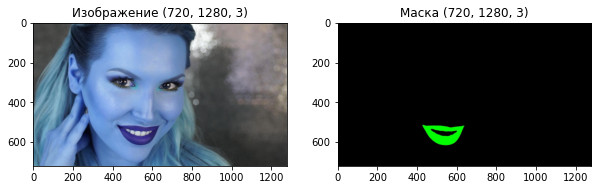

In [8]:
#посмотрим данные
image = cv2.imread(images_path + files_names_list[10], cv2.COLOR_BGR2RGB)
mask = cv2.imread(masks_path + masks_names_list[10], cv2.COLOR_BGR2RGB)

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(image)
ax[0].set_title(f'Изображение {image.shape}')
ax[1].imshow(mask)
ax[1].set_title(f'Маска {mask.shape}')
plt.show()

In [9]:
data = df[['filename', 'mask']]
data.head()

,filename,mask
0,image00000001.jpg,mask00000001.png
1,image00000002.jpg,mask00000002.png
2,image00000003.jpg,mask00000003.png
3,image00000004.jpg,mask00000004.png
4,image00000005.jpg,mask00000005.png


In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [11]:
#инициализация модели
segmodel = smp.Linknet(encoder_name = 'resnet34', 
                    encoder_weights = 'imagenet', 
                    in_channels = 3, 
                    classes = 1, # число каналов маски
                    activation = 'sigmoid').to(device)

preprocess_input = smp.encoders.get_preprocessing_fn('resnet34', pretrained='imagenet')

In [12]:
#класс датасета
class CustomDataset(Dataset):
    def __init__(self, data, preprocessing=None):
        # загружаем данные из датасета
        self.data = data
        self.preprocessing = preprocessing
        self.image_arr = self.data.iloc[:,0] # имена файлов картинок из датасета
        self.label_arr = self.data.iloc[:,1] # имена файлов масок из датасета
        self.data_len = len(self.data.index)
        
    def __len__(self):
        return self.data_len
        
    def __getitem__(self, index):
       # загружаем картинки
        img = cv2.imread(images_path+self.image_arr[index]) 
        img = cv2.cvtColor(cv2.resize(img, (256, 256)), cv2.COLOR_BGR2RGB)
        img = np.asarray(img).astype('float')
        
        if self.preprocessing:
            img = self.preprocessing(img)
            img = torch.as_tensor(img)
        
        else:
            img = torch.as_tensor(img)
            img /= 255.0
        
        img = img.permute(2,0,1)
        
        # загружаем маски
        mask = cv2.imread(masks_path+self.label_arr[index])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)        
        cls_mask = np.where(mask > 50, 1, 0)[:,:,1]
        cls_mask = cls_mask.astype('float')
        cls_mask = cv2.resize(cls_mask, (256, 256))

        masks = [cls_mask]
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        
        
        return (img.float(), masks)

In [13]:
#разделение датасета на train и test
X_train, X_test = train_test_split(data, test_size=0.3, random_state=42)

#сбрасываем индексы
X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)

#создаем датасеты
train_data = CustomDataset(X_train, preprocessing=preprocess_input)
test_data = CustomDataset(X_test, preprocessing=preprocess_input)

#создаем даталодеры
train_data_loader = DataLoader(train_data, batch_size=8, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size=4, shuffle=False)

C:\Users\User\AppData\Local\Temp/ipykernel_78660/973253793.py:38: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  masks = torch.as_tensor(masks, dtype=torch.uint8)
C:\Users\User\AppData\Local\Temp/ipykernel_78660/973253793.py:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:248.)
  masks = torch.as_tensor(masks, dtype=torch.uint8)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([8, 3, 256, 256]) torch.Size([8, 1, 256, 256])
tensor(-2.0837) tensor(2.6051)
tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


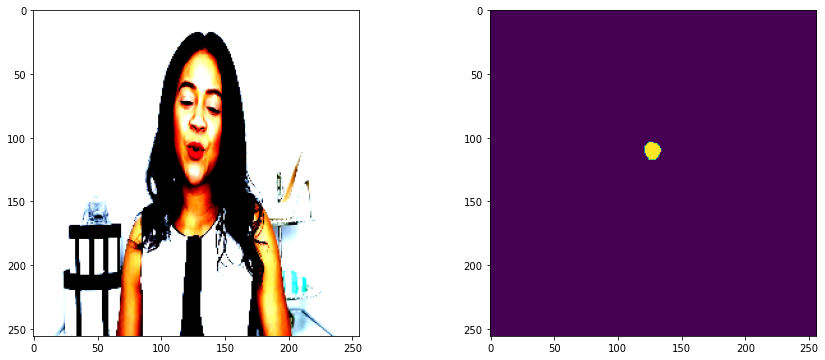

In [14]:
#просмотр данных из даталоадера
for img, target in train_data_loader:
    print(img.shape, target.shape)
    print(img[0].min(), img[0].max())
    print(target[0].min(), target[0].max())
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    ax[0].imshow(img[0].permute(1, 2, 0))
    ax[1].imshow(target[0].permute(1, 2, 0)[..., 0])
    break

In [79]:
#определение критерия, метрики и оптимизатора
criterion = smp.utils.losses.DiceLoss()
metrics = [smp.utils.metrics.IoU(),]
optimizer = torch.optim.Adam(params=segmodel.parameters(), lr=0.001)

#определение тренировочных и валидационных эпох
train_epoch = smp.utils.train.TrainEpoch(
    segmodel, 
    loss=criterion, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True)

valid_epoch = smp.utils.train.ValidEpoch(
    segmodel, 
    loss=criterion, 
    metrics=metrics,
    device=device,
    verbose=True)


In [80]:
# обучение модели
num_epochs = 10
linknet_train_iou = []
linknet_valid_iou = []

for i in range(num_epochs):
    print(f'Epoch: {i + 1}')
    train_logs = train_epoch.run(train_data_loader)
    valid_logs = valid_epoch.run(test_data_loader)
    
    linknet_train_iou.append(train_logs['iou_score'])
    linknet_valid_iou.append(valid_logs['iou_score'])

Epoch: 1
valid: 100%|██████████| 2141/2141 [08:17<00:00,  4.30it/s, dice_loss - 0.06734, iou_score - 0.8788]
Epoch: 2
valid: 100%|██████████| 2141/2141 [06:36<00:00,  5.40it/s, dice_loss - 0.03097, iou_score - 0.9407]
Epoch: 3
valid: 100%|██████████| 2141/2141 [06:32<00:00,  5.46it/s, dice_loss - 0.03069, iou_score - 0.941] 
Epoch: 4
valid: 100%|██████████| 2141/2141 [06:33<00:00,  5.43it/s, dice_loss - 0.04721, iou_score - 0.9152]
Epoch: 5
valid: 100%|██████████| 2141/2141 [06:41<00:00,  5.34it/s, dice_loss - 0.02835, iou_score - 0.9452]
Epoch: 6
valid: 100%|██████████| 2141/2141 [06:41<00:00,  5.33it/s, dice_loss - 0.03524, iou_score - 0.9326]
Epoch: 7
valid: 100%|██████████| 2141/2141 [06:51<00:00,  5.21it/s, dice_loss - 0.02391, iou_score - 0.9535]
Epoch: 8
valid: 100%|██████████| 2141/2141 [06:46<00:00,  5.26it/s, dice_loss - 0.0245, iou_score - 0.9524] 
Epoch: 9
valid: 100%|██████████| 2141/2141 [06:41<00:00,  5.33it/s, dice_loss - 0.02274, iou_score - 0.9557]
Epoch: 10
valid: 10

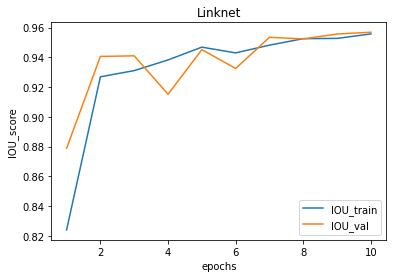

In [81]:
x = np.arange(1,11,1)
y = linknet_train_iou
y2 = linknet_valid_iou

plt.plot(x,y,label='IOU_train')
plt.plot(x,y2,label='IOU_val')

plt.title(f"Linknet")   
plt.ylabel('IOU_score')   
plt.xlabel('epochs')   
plt.legend()
plt.show()

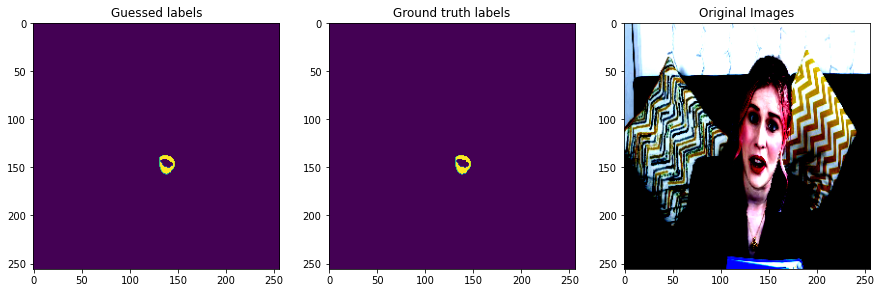

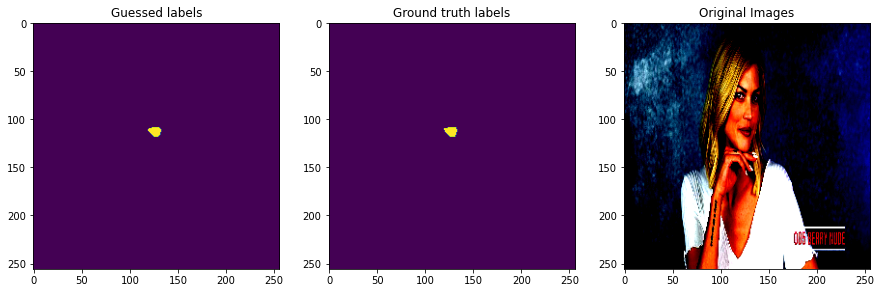

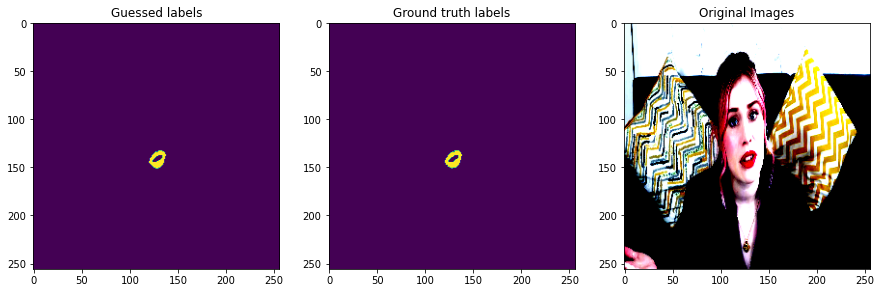

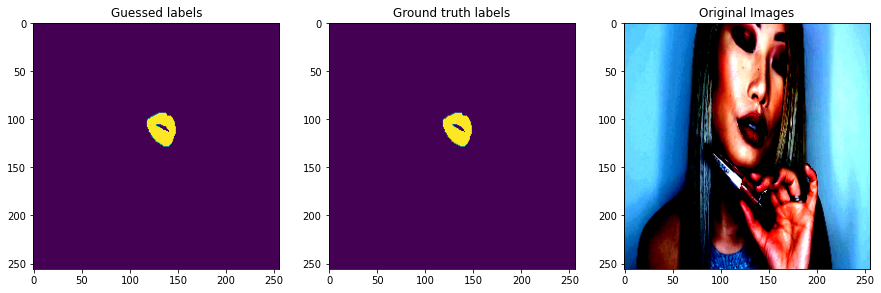

In [90]:
#предсказание модели
for i, data in enumerate(test_data_loader):
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    
    outputs = segmodel(images)
    
    f, axarr = plt.subplots(1,3, figsize=(15, 6))

    for j in range(0, 4):
        axarr[0].imshow(outputs.detach().cpu()[i, ].permute(1, 2, 0))
        axarr[0].set_title('Guessed labels')
        
        axarr[1].imshow(labels[i, ].cpu().permute(1, 2, 0))
        axarr[1].set_title('Ground truth labels')
        
        image = images[i].permute(1, 2, 0)
        axarr[2].imshow(image.cpu())
        axarr[2].set_title('Original Images')
        plt.show()
    if i > 2:
        break